In [1]:
import ee
import geemap

import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, balanced_accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import json
from ipyleaflet import GeoJSON
import os
import pickle 
from glob import glob

In [9]:
class_values = [0,1,2,3,4,5,6]
class_palette = ['3388ff', 'e72a08', '3ba702', 'e4f406', '44ff00','c88d0e', 'bab7b0']
labels = { 0:'water',
         1:'bare_soil',
         2:'forest',
         3:'crop_annual',
         4:'crop_perennial',
         5:'pasture',
         6:'urban'}

## Load training data

In [16]:
training_data = None
for file in glob('../data/train/*' ):
    print(file)
    with open(file, 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
        if training_data is None:
            training_data = pickle.load( f)
        else:
            training_data = training_data.merge(pickle.load(f))

../data/train\train_test_data.pickle


In [9]:
training_data.size().getInfo()

96820

## Load external validation data

In [10]:
collection = None
for file in glob('../data/test/*' ):
    print(file)
    with open(file, 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
        if collection is None:
            collection = pickle.load( f)
        else:
            collection = collection.merge(pickle.load(f))

../data/test\data_41705538_11759867_data2.pickle
../data/test\data_45088599_2096907_data2.pickle
../data/test\data_45639137_21235329_data2.pickle
../data/test\data_46789047_23699069_data2.pickle
../data/test\data_validation_41925184_11792395_data2.pickle
../data/test\data_validation_4649515_23511.pickle
../data/test\data_validation_46822354_23368611_data2.pickle


In [11]:
collection.size().getInfo()

249567

## Create map object

In [12]:
Map = geemap.Map(center=[-15, -57] )

# Model selection

In [13]:
#Adds a column of deterministic pseudorandom numbers. 
sample = training_data.randomColumn()

split = 0.5

training_set = sample.filter(ee.Filter.lt('random', split))
validation_set = sample.filter(ee.Filter.gte('random', split))

## Choose one model to run and test

In [15]:
#Train a CART classifier with default parameters.
classifier = ee.Classifier.smileCart().train(training_set.filter(ee.Filter.notNull(['landcover']) ), label, bands)

#Train a CART classifier with default parameters.
classifier = ee.Classifier.smileGradientTreeBoost().train(training_set.filter(ee.Filter.notNull(['landcover']) ), label, bands)

#Train a CART classifier with default parameters.
classifier = ee.Classifier.smileRandomForest().train(training_set.filter(ee.Filter.notNull(['landcover']) ), label, bands)

## Create the validation result table

In [34]:
validation_set = collection.filter(ee.Filter.notNull(['landcover']) )

In [35]:
validated = validation_set.classify(classifier)

In [36]:
geemap.ee_to_csv(validated, 'test_result_CART.csv', verbose = True)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\lucas.m.pontes\OneDrive - EDITORA E DISTRIBUIDORA EDUCACIONAL S A\Biblio\Udacity\ML Engineer\satellite image classifier\model\test_CART_v1.csv


## Load validation result as a pandas dataframe and calculate the metrics

In [21]:
#Remember to change the name of the file
val = pd.read_csv('../model/test_CART.csv')

C:\Users\lucas.m.pontes\Anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [22]:
accuracy_score(val['landcover'], val['classification'])

0.9999586631668148

In [23]:
balanced_accuracy_score(val['landcover'], val['classification'])

0.999961264332197

In [24]:
precision_score(val['landcover'], val['classification'], average = 'weighted')

0.999958672333426

In [25]:
confusion_matrix(val['landcover'], val['classification'])

array([[10324,     0,     0,     0,     0,     0,     0],
       [    0,  9229,     0,     0,     0,     0,     0],
       [    0,     0,  9017,     0,     0,     0,     0],
       [    0,     0,     2,  7374,     0,     0,     0],
       [    0,     0,     0,     0,   195,     0,     0],
       [    0,     0,     0,     0,     0,  7558,     0],
       [    0,     0,     0,     0,     0,     0,  4684]], dtype=int64)

In [31]:
val['label'] = val.landcover.map(labels)

In [27]:
val.label.unique()

array(['water', 'bare_soil', 'forest', 'crop_annual', 'urban', 'pasture',
       'crop_perennial'], dtype=object)

In [32]:
conf_mat = confusion_matrix(val['true_label'], val['predicted_label'],labels=val.label.unique())

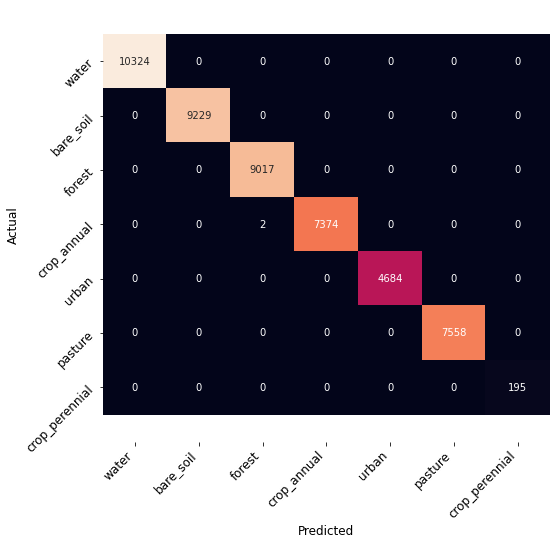

In [44]:
#conf_mat = confusion_matrix(val['landcover'], val['classification'])
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(conf_mat, annot=True, fmt='d',cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(val.label.unique(), rotation = 45, ha="right",size=12)
ax.set_xticklabels(val.label.unique(), rotation = 45, ha="right",size=12)
plt.ylabel('Actual',size=12)
plt.xlabel('Predicted',size=12);

# Predict

#### Drawn a polygon over the map below you wish to predict

In [15]:
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [ ]:
image = (ee.ImageCollection('COPERNICUS/S2_SR')
                     .filterBounds(Map.user_rois.geometry())
                     .filterDate('2019-09-01', '2019-12-31')
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))
                     .median().clip(Map.user_rois.geometry())
                     )

            # Add the image layer to the map and display it.
            Map.add_ee_layer(
                image, {'bands': ['B4', 'B3', 'B2'],
                        'min': 0, 'max': 2000}, 'sentinel')
            

In [9]:
# Classify the image with the same bands used for training.
result = image.select(bands).classify(classifier)

In [10]:
landcover = result.set('classification_class_values', class_values )
landcover = landcover.set('classification_class_palette', class_palette )

In [11]:
legend_dict = {
    'Water': '3388ff',
    'Bare soil': 'e72a08',
    'Forest': '3ba702',
    'Annual crop': 'e4f406',
    'Perennial crop': '44ff00',
    'Pasture': 'c88d0e',
    'Urban area': 'bab7b0'
}

Map.addLayer(landcover, {}, 'classified')
Map.add_legend(legend_dict=legend_dict) 

Map(bottom=146194.0, center=[-19.93978728199503, -51.097412109375], controls=(WidgetControl(options=['position…

# Save fitted model

In [31]:
with open('trained_model.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(classifier, f)
    